Q.1

Q.1

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
n_samples = 1000
n_features = 7
rho = 0.85  # high pairwise correlation
cov = np.full((n_features, n_features), rho)
np.fill_diagonal(cov, 1.0)
X_raw = np.random.multivariate_normal(mean=np.zeros(n_features), cov=cov, size=n_samples)

In [3]:
true_w = np.array([3.5, -2.0, 1.5, 0.0, 0.8, -1.2, 2.0])
intercept_true = 4.0
noise = np.random.normal(0, 1.5, size=n_samples)
y_raw = X_raw.dot(true_w) + intercept_true + noise

In [4]:
df = pd.DataFrame(X_raw, columns=[f"X{i+1}" for i in range(n_features)])
df["y"] = y_raw

In [5]:
X = df[[f"X{i+1}" for i in range(n_features)]].values
y = df["y"].values.reshape(-1, 1)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
Xs = (X - X_mean) / X_std

In [6]:
X_design = np.hstack([np.ones((n_samples, 1)), Xs])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_design, y, test_size=0.2, random_state=1)


In [8]:
def ridge_cost_and_grad(w, X, y, alpha):
    n = X.shape[0]
    preds = X.dot(w)
    error = preds - y
    cost = (0.5 / n) * np.sum(error**2) + (alpha / (2 * n)) * np.sum(w[1:]**2)
    grad = (1.0 / n) * X.T.dot(error)
    reg = np.vstack([np.zeros((1,1)), (alpha / n) * w[1:]])
    grad = grad + reg
    return cost, grad

In [9]:
def gradient_descent_ridge(X, y, alpha, lr, n_iters=5000, tol=1e-9):
    w = np.zeros((X.shape[1], 1), dtype=np.float64)
    costs = []
    for it in range(n_iters):
        cost, grad = ridge_cost_and_grad(w, X, y, alpha)
        if not np.isfinite(cost) or not np.all(np.isfinite(grad)):
            costs.append(np.nan)
            break
        w = w - lr * grad
        costs.append(float(cost))
        if it > 0 and abs(costs[-2] - costs[-1]) < tol:
            break
    return w, np.array(costs)

In [10]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
alphas = [1e-15, 1e-10, 1e-5, 1e-3, 0.0, 1.0, 10.0, 20.0]

In [11]:
results = []
for lr in learning_rates:
    for alpha in alphas:
        w_hat, costs = gradient_descent_ridge(X_train, y_train, alpha=alpha, lr=lr, n_iters=5000)
        preds_test = X_test.dot(w_hat)
        if not np.all(np.isfinite(preds_test)):
            r2 = np.nan
        else:
            r2 = r2_score(y_test, preds_test)
        final_cost = float(costs[-1]) if costs.size > 0 else np.nan
        iters = int(costs.size)
        w_norm = float(np.linalg.norm(w_hat[1:])) if np.all(np.isfinite(w_hat)) else np.nan
        results.append({
            "learning_rate": lr,
            "alpha": alpha,
            "final_cost": final_cost,
            "r2_test": r2,
            "iters": iters,
            "w_norm": w_norm
        })

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in redu

In [12]:
results_df = pd.DataFrame(results)
results_sorted = results_df.sort_values(["r2_test", "final_cost"], ascending=[False, True]).reset_index(drop=True)



In [13]:
results_sorted.to_csv("ridge_gd_grid_results.csv", index=False)
print("Top 10 parameter combos (by test R^2):")
print(results_sorted.head(10))

Top 10 parameter combos (by test R^2):
   learning_rate         alpha  final_cost   r2_test  iters    w_norm
0           0.01  1.000000e+01    1.312974  0.869029   5000  4.747702
1           0.10  1.000000e+01    1.312973  0.869029    590  4.749134
2           0.01  1.000000e+00    1.177654  0.868490   5000  5.062890
3           0.10  1.000000e+00    1.177653  0.868472    641  5.066078
4           0.01  1.000000e-03    1.161505  0.868327   5000  5.101037
5           0.01  1.000000e-05    1.161489  0.868327   5000  5.101075
6           0.01  1.000000e-10    1.161489  0.868327   5000  5.101075
7           0.01  1.000000e-15    1.161489  0.868327   5000  5.101075
8           0.01  0.000000e+00    1.161489  0.868327   5000  5.101075
9           0.10  1.000000e-03    1.161503  0.868306    648  5.104510



Best combination (selected): {'learning_rate': 0.01, 'alpha': 10.0, 'final_cost': 1.3129737191896418, 'r2_test': 0.8690291399819027, 'iters': 5000.0, 'w_norm': 4.7477015136360174}


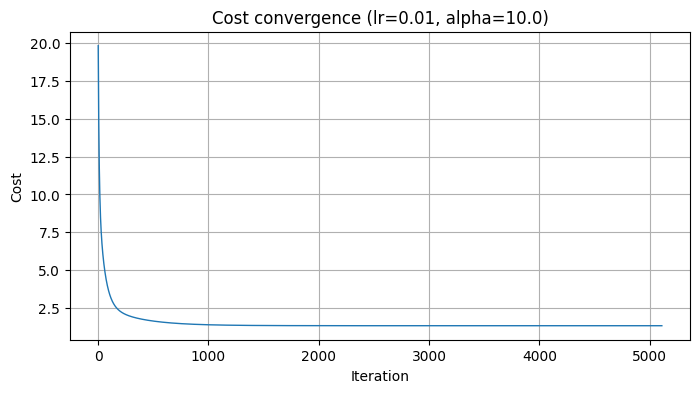

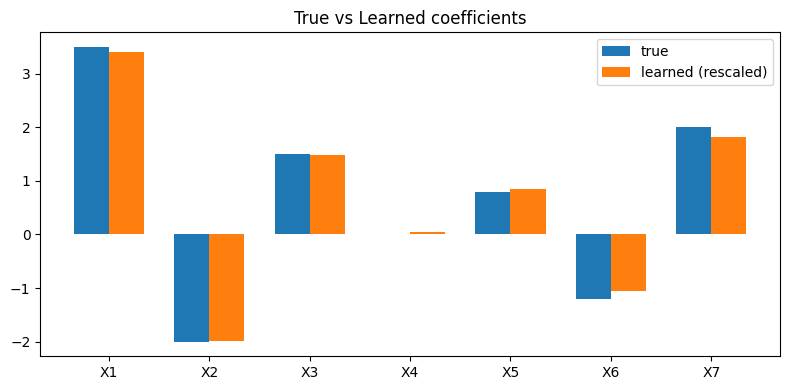

In [18]:
best = results_sorted.loc[0]
print("\nBest combination (selected):", best.to_dict())

if np.isfinite(best.final_cost):
    lr_best = float(best.learning_rate)
    alpha_best = float(best.alpha)
    w_best, costs_best = gradient_descent_ridge(X_train, y_train, alpha=alpha_best, lr=lr_best, n_iters=20000)
    plt.figure(figsize=(8,4))
    plt.plot(costs_best, linewidth=1)
    plt.title(f"Cost convergence (lr={lr_best}, alpha={alpha_best})")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.grid(True)
    plt.show()
    coef_learned = (w_best[1:].flatten() / X_std)  # because w learned on standardized X
    indices = np.arange(n_features)
    width = 0.35
    plt.figure(figsize=(8,4))
    plt.bar(indices - width/2, true_w, width, label="true")
    plt.bar(indices + width/2, coef_learned, width, label="learned (rescaled)")
    plt.xticks(indices, [f"X{i+1}" for i in range(n_features)])
    plt.title("True vs Learned coefficients")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Best combo diverged; check results CSV for valid combos.")


Q,2

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

In [22]:
df = pd.read_csv("Hitters.csv")

print("Original Data Shape:", df.shape)
print("\nMissing values before cleaning:\n", df.isnull().sum())

# Drop rows with missing target (Salary)
df = df.dropna(subset=['Salary'])

# Fill other missing values if any (mean for numeric, mode for categorical)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())

print("\nMissing values after cleaning:\n", df.isnull().sum())

# ----- Handle categorical variables -----
df = pd.get_dummies(df, drop_first=True)

# ----- (b) Separate input and output features -----
X = df.drop('Salary', axis=1)
y = df['Salary']

# ----- Feature Scaling -----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----- Split into train/test sets -----
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# ----- (c) Fit Linear, Ridge, and Lasso Models -----
ridge_alpha = 0.5748
lasso_alpha = 0.5748

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=ridge_alpha),
    'Lasso Regression': Lasso(alpha=lasso_alpha)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'R² Score': r2, 'RMSE': rmse}

# ----- (d) Evaluate Model Performance -----
results_df = pd.DataFrame(results).T.sort_values(by='R² Score', ascending=False)
print("\n==================== Model Evaluation ====================")
print(results_df)
print("===========================================================\n")

# Identify best model
best_model = results_df['R² Score'].idxmax()
print(f"Best Model: {best_model}")

# ----- Explanation -----
if best_model == 'Ridge Regression':
    reason = ("Ridge performs best because it handles multicollinearity "
              "by penalizing large coefficients without driving them to zero, "
              "leading to better generalization.")
elif best_model == 'Lasso Regression':
    reason = ("Lasso performs best because it performs feature selection "
              "by shrinking some coefficients exactly to zero, removing irrelevant predictors.")
else:
    reason = ("Linear Regression performs best likely because regularization "
              "is not required — the data might not have high multicollinearity.")

print("\nWhy does it perform best?\n", reason)

Original Data Shape: (322, 20)

Missing values before cleaning:
 AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

Missing values after cleaning:
 AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

==================== Model Evaluation ====================
                   R² Score        RMSE
Ridge Regression   0.299789  355.877218
Lasso Regression   0.299065  356.061043
Linear Regression  0.290745  358.168041

Best Model: Ridge Regression

Why d

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e+04, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(


Q.3

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_squared_error

# ---- Step 1: Load the Boston Housing dataset using read_csv ----
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
df = pd.read_csv(url)

print("Dataset shape:", df.shape)
print("\nFirst 5 rows of data:")
print(df.head())

# ---- Step 2: Separate features and target ----
X = df.drop("medv", axis=1)   # medv = Median value of owner-occupied homes (target)
y = df["medv"]

# ---- Step 3: Split data into training and test sets ----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- Step 4: Standardize (scale) features ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- Step 5: Ridge Regression with Cross Validation ----
alphas = np.logspace(-3, 3, 50)  # test alpha values from 0.001 to 1000
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

ridge_best_alpha = ridge_cv.alpha_
ridge_pred = ridge_cv.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))

# ---- Step 6: Lasso Regression with Cross Validation ----
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

lasso_best_alpha = lasso_cv.alpha_
lasso_pred = lasso_cv.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))

# ---- Step 7: Display results ----
results = pd.DataFrame({
    "Model": ["Ridge Regression (CV)", "Lasso Regression (CV)"],
    "Best Alpha (λ)": [ridge_best_alpha, lasso_best_alpha],
    "R² Score": [ridge_r2, lasso_r2],
    "RMSE": [ridge_rmse, lasso_rmse]
})

print("\n==================== Model Evaluation ====================")
print(results)
print("===========================================================\n")

# ---- Step 8: Determine the best model ----
best_model = results.loc[results["R² Score"].idxmax(), "Model"]
print(f" Best Performing Model: {best_model}")

if best_model.startswith("Ridge"):
    reason = (
        "Ridge Regression performs best because it handles multicollinearity well, "
        "shrinking coefficients smoothly without removing features, leading to better generalization."
    )
else:
    reason = (
        "Lasso Regression performs best because it performs feature selection by setting "
        "some coefficients to zero, improving interpretability."
    )

print("\nReason:\n", reason)

Dataset shape: (506, 14)

First 5 rows of data:
      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  

==================== Model Evaluation ====================
                   Model  Best Alpha (λ)  R² Score      RMSE
0  Ridge Regression (CV)        2.682696  0.667965  4.934511
1  Lasso Regression (CV)        0.001000  0.668713  4.928949

 Best Performing Model: Lasso Regression (CV)

Reason:
 Lasso Regression perf

Q.4


Dataset shape: (150, 4)
Classes: ['setosa' 'versicolor' 'virginica']
Class 0 (setosa) trained | Final Cost: 0.0067
Class 1 (versicolor) trained | Final Cost: 0.4787
Class 2 (virginica) trained | Final Cost: 0.0924

==================== RESULTS ====================
Model Accuracy on Test Data: 0.9000


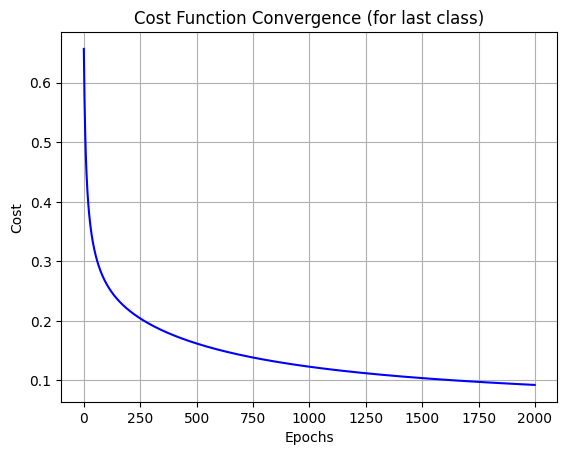

In [24]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# ---------- Step 1: Load the Iris dataset ----------
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

print("Dataset shape:", X.shape)
print("Classes:", class_names)

# ---------- Step 2: Split dataset ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Step 3: Standardize features ----------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---------- Step 4: Define helper functions ----------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, weights, bias, lam=0):
    n = len(y)
    z = np.dot(X, weights) + bias
    h = sigmoid(z)
    cost = - (1/n) * np.sum(y*np.log(h + 1e-15) + (1 - y)*np.log(1 - h + 1e-15))
    cost += (lam / (2*n)) * np.sum(weights ** 2)
    return cost

def train_binary_logistic(X, y, lr=0.1, epochs=2000, lam=0):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0
    cost_history = []

    for _ in range(epochs):
        z = np.dot(X, weights) + bias
        h = sigmoid(z)
        dw = (1/n_samples) * np.dot(X.T, (h - y)) + (lam/n_samples) * weights
        db = (1/n_samples) * np.sum(h - y)
        weights -= lr * dw
        bias -= lr * db
        cost_history.append(compute_cost(X, y, weights, bias, lam))

    return weights, bias, cost_history

def predict_binary(X, weights, bias):
    return sigmoid(np.dot(X, weights) + bias)

# ---------- Step 5: Train One-vs-Rest Models ----------
n_classes = len(np.unique(y_train))
weights_all, biases_all = [], []

for c in range(n_classes):
    y_train_binary = np.where(y_train == c, 1, 0)
    weights, bias, cost_history = train_binary_logistic(X_train, y_train_binary, lr=0.1, epochs=2000)
    weights_all.append(weights)
    biases_all.append(bias)
    print(f"Class {c} ({class_names[c]}) trained | Final Cost: {cost_history[-1]:.4f}")

# ---------- Step 6: Predict Multiclass ----------
def predict_multiclass(X, weights_all, biases_all):
    probs = []
    for w, b in zip(weights_all, biases_all):
        probs.append(predict_binary(X, w, b))
    probs = np.array(probs).T
    return np.argmax(probs, axis=1)

y_pred = predict_multiclass(X_test, weights_all, biases_all)

# ---------- Step 7: Evaluate ----------
accuracy = accuracy_score(y_test, y_pred)
print("\n==================== RESULTS ====================")
print(f"Model Accuracy on Test Data: {accuracy:.4f}")
print("=================================================")

# ---------- Step 8: Plot cost curve for last trained class ----------
plt.plot(range(len(cost_history)), cost_history, color='blue')
plt.title("Cost Function Convergence (for last class)")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.grid(True)
plt.show()